In [ ]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

# Load data
df = pd.read_csv("ercot_load_data.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index("date", inplace=True)
df.sort_index(inplace=True)
df = df[df['values'] >= 60]
values = df['values']  # Use the first n observations
dates = df.index  # Corresponding dates

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(dates, values, label="Observed Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.savefig("observed_data.png")
plt.show()


Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺  98% 0:01:17 / 2:13:34

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 75322 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


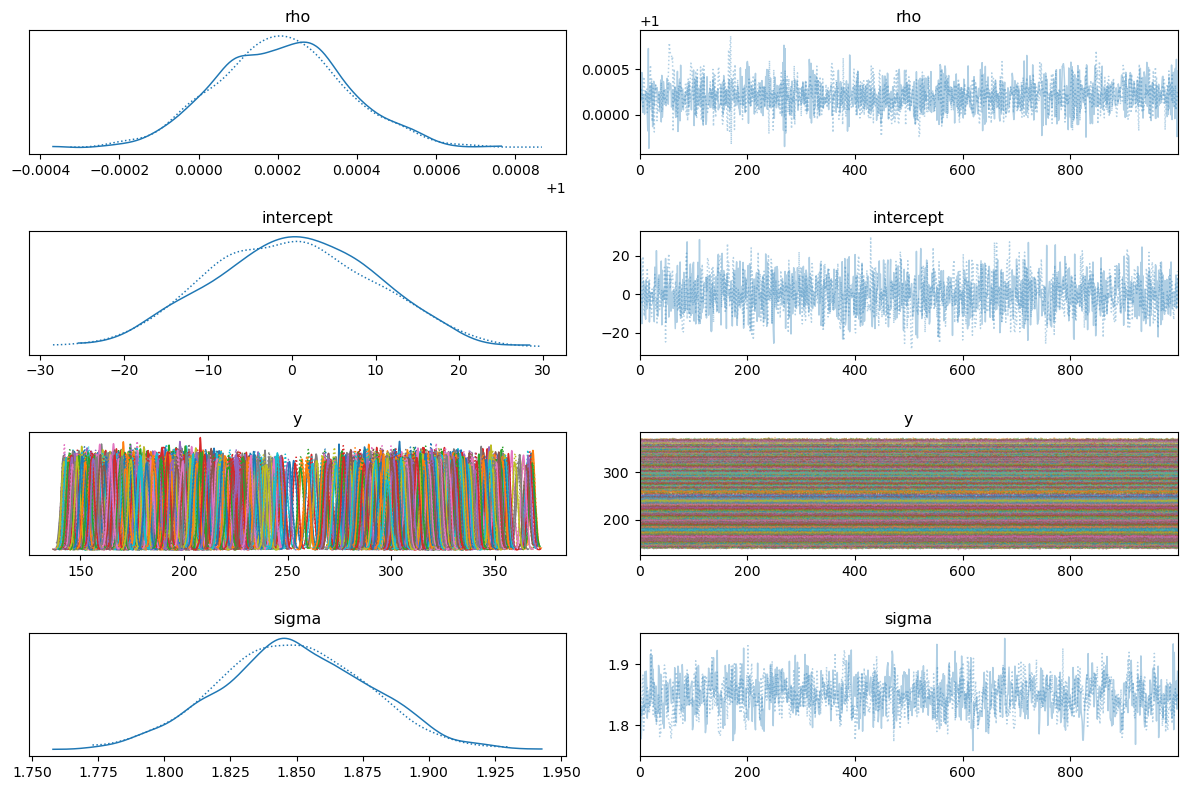

Sampling: [y_like]


Output()

KeyError: 'y'

In [6]:
n = len(values)

# Bayesian AR(1) Model
with pm.Model() as model:
    # Priors for AR(1) parameters
    rho = pm.Normal("rho", mu=0, sigma=1)  # AR coefficient
    sigma = pm.HalfNormal("sigma", sigma=1)  # Noise term
    intercept = pm.Normal("intercept", mu=0, sigma=10)  # Optional intercept term

    # AR(1) Process
    y = pm.AR("y", rho=rho, sigma=sigma, shape=n)

    # Likelihood
    y_like = pm.Normal("y_like", mu=y, sigma=sigma, observed=values)

    # Sample the posterior
    trace = pm.sample(1000, tune=1000, return_inferencedata=True, cores=1)

# Plot Results
az.plot_trace(trace)
plt.tight_layout()
plt.savefig("bayesian_trace.png")
plt.show()

# Posterior Predictive Sampling
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

# Extract posterior samples
posterior_samples = posterior_predictive["y"]

# Compute posterior mean and credible intervals
posterior_mean = posterior_samples.mean(axis=0)
lower_bound = np.percentile(posterior_samples, 2.5, axis=0)
upper_bound = np.percentile(posterior_samples, 97.5, axis=0)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(dates, values, label="Observed Data", color="blue")
plt.plot(dates, posterior_mean, label="Posterior Mean", color="red")
plt.fill_between(dates, lower_bound, upper_bound, color="red", alpha=0.3, label="95% Credible Interval")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.savefig("observed_predicted.png")
plt.show()


In [ ]:
# Inspect the shape of posterior_samples
print(f"Original shape of posterior_samples: {posterior_samples.shape}")

# Ensure correct shape: (num_samples, num_time_points)
posterior_samples = posterior_samples.squeeze()  # Remove any singleton dimensions
print(f"Shape after squeeze: {posterior_samples.shape}")

# Check dimensionality; if still (1000, 1, 100), reshape or index
if posterior_samples.ndim > 2:
    posterior_samples = posterior_samples[:, 0, :]  # Remove the redundant dimension
    print(f"Shape after indexing: {posterior_samples.shape}")

# Compute posterior mean and credible intervals
posterior_mean = posterior_samples.mean(axis=0)  # Reduce to (100,)
lower_bound = np.percentile(posterior_samples, 2.5, axis=0)  # Reduce to (100,)
upper_bound = np.percentile(posterior_samples, 97.5, axis=0)  # Reduce to (100,)

# Validate shapes before plotting
print(f"x shape: {x.shape}, posterior_mean shape: {posterior_mean.shape}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="Observed Data")
plt.plot(x, posterior_mean, label="Posterior Mean", color='r')
plt.fill_between(x, lower_bound, upper_bound, color='r', alpha=0.3, label="95% Credible Interval")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:

# Compute MAPE
mape = np.mean(np.abs((y - posterior_mean) / y)) * 100
 
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pmd
from pmdarima import model_selection

# Train-Test Split
train, test = model_selection.train_test_split(y, train_size=150)

# Fit an ARIMA model using auto_arima
arima = pmd.auto_arima(
    train,
    error_action="ignore",
    trace=True,
    suppress_warnings=True,
    seasonal=False,  # Set to False as the data lacks seasonality
    maxiter=5
)

# Forecast on the test set
forecasts = arima.predict(n_periods=test.shape[0])

# Calculate MAPE
mape = np.mean(np.abs((test - forecasts) / test)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot actual test vs. forecasts
x_test = np.arange(test.shape[0])
plt.figure(figsize=(10, 6))
plt.plot(x_test, test, color="red", label="Actual")
plt.plot(x_test, forecasts, color="blue", label="Forecast")
plt.title("Actual Test Samples vs. Forecasts")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.savefig("pdmarima.png")
plt.show()

In [ ]:
pip freeze > requirements.txt